In [9]:
from numpy import *

#加载数据集
def loadData(filename):
    dataMat = []
    fr = open(filename)
    for line in fr.readlines():
        line = line.strip().split('\t')
        for i in range(len(line)):
            line[i] = float(line[i])
        dataMat.append(line)
    return dataMat

#切分数据集，对于特征属性feature，以value作为中点，小于value作为数据集1，大于value作为数据集2
def binSplitData(data, feature, value):
    #nonzero，当使用布尔数组直接作为下标对象或者元组下标对象中有布尔数组时，
    #都相当于用nonzero()将布尔数组转换成一组整数数组，然后使用整数数组进行下标运算。
    mat1 = data[nonzero(data[:,feature] > value)[0],:]
    mat2 = data[nonzero(data[:,feature] <= value)[0],:]
    return mat1, mat2

#找到数据切分的最佳位置，遍历所有特征及其可能取值找到使误差最小化的切分阈值
#生成叶子节点,即计算属于该叶子的所有数据的label的均值（回归树使用总方差）
def regLeaf(data):
    return mean(data[:,-1])

#误差计算函数：总方差
def regErr(data):
    return var(data[:,-1]) * shape(data)[0]

#最佳切分查找函数
def chooseBestSplit(data, leafType=regLeaf, errType=regErr, ops=(1,4)):
    #容许的误差下降值
    tolS = ops[0]
    #切分的最少样本数
    tolN = ops[1]
    #如果数据的y值都相等，即属于一个label，则说明已经不用再分了，则返回叶子节点并退出
    if len(set(data[:,-1].T.tolist()[0])) == 1:
        return None, leafType(data)
    #否则，继续分
    m,n = shape(data)
    #原数据集的误差
    s = regErr(data)
    #最佳误差(先设为极大值),最佳误差对应的特征的index，和对应的使用的切分值
    best_s =  inf
    best_index = 0
    best_val = 0
    for feat_index in range(n-1):
        for val in set(data[:,feat_index].T.A.tolist()[0]):
            #根据特征feat_index和其对应的划分取值val将数据集分开
            mat1, mat2 = binSplitData(data, feat_index, val)
            #若某一个数据集大小小于tolN，则停止该轮循环
            if (shape(mat1)[0] < tolN) or (shape(mat2)[0] < tolN):
                continue
            new_s = errType(mat1) + errType(mat2)
            if new_s < best_s:
                best_s = new_s
                best_index = feat_index
                best_val = val
    #如果最佳的误差相较于总误差下降的不多，则停止分支，返回叶节点
    if (s-best_s) < tolS:
        return None, leafType(data)
    #如果划分出来的两个数据集，存在大小小于tolN的，也停止分支，返回叶节点
    mat1, mat2 = binSplitData(data, best_index, best_val)
    if (shape(mat1)[0] < tolN) or (shape(mat2)[0] < tolN):
        return None, leafType(data)
    #否则，继续分支，返回最佳的特征和其选取的值
    return best_index, best_val

#创建回归树
def createTree(data, leafType=regLeaf, errType=regErr, ops = (1,4)):
    #找到最佳的划分特征以及其对应的值
    feat, val = chooseBestSplit(data, leafType, errType, ops)
    #若达到停止条件，feat为None并返回数值（回归树）或线性方程（模型树）
    if feat is None:
        return val
    #若未达到停止条件，则根据feat和对应的val将数据集分开，然后左右孩子递归地创建回归树
    #tree 存储了当前根节点划分的特征以及其对应的划分值，另外，左右孩子也作为字典存储
    rgtree = {}
    rgtree['spInd'] = feat
    rgtree['spVal'] = val
    lset, rset = binSplitData(data,feat,val)
    rgtree['left'] = createTree(lset,leafType, errType, ops)
    rgtree['right'] = createTree(rset,leafType, errType, ops)
    return rgtree

#测试上述函数，分类单特征样本
data = mat(loadData('ex00.txt'))
rgtree = createTree(data)
print(rgtree)
#测试上述函数，分类多特征样本
data1 = mat(loadData('ex0.txt'))
rgtree1 = createTree(data1)
print(rgtree1)

{'spVal': 0.48813, 'right': -0.04465028571428572, 'left': 1.0180967672413792, 'spInd': 0}
{'spVal': 0.39435, 'right': {'spVal': 0.197834, 'right': -0.023838155555555553, 'left': 1.0289583666666666, 'spInd': 1}, 'left': {'spVal': 0.582002, 'right': 1.980035071428571, 'left': {'spVal': 0.797583, 'right': 2.9836209534883724, 'left': 3.9871632, 'spInd': 1}, 'spInd': 1}, 'spInd': 1}


## 剪枝
之前所做的一些关于容许误差下降值tolS和tolN属于一种预剪枝，但是根据数据量级的不同，需要时不时地修改设置的阈值，太繁琐，下面展示一个例子。
给定两个数据集‘ex00.txt’和‘ex2.txt’，均为单一特征的样本数据。画出二者的分布图：

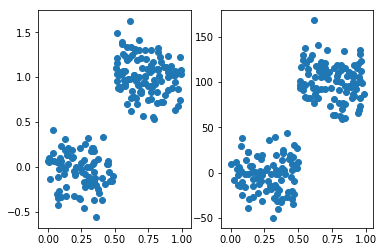

第一棵树：
 {'spVal': 0.48813, 'right': -0.04465028571428572, 'left': 1.0180967672413792, 'spInd': 0}
第二棵树：
 {'spVal': 0.499171, 'right': {'spVal': 0.457563, 'right': {'spVal': 0.126833, 'right': {'spVal': 0.084661, 'right': {'spVal': 0.044737, 'right': 4.091626, 'left': -2.544392714285715, 'spInd': 0}, 'left': 6.509843285714284, 'spInd': 0}, 'left': {'spVal': 0.373501, 'right': {'spVal': 0.335182, 'right': {'spVal': 0.324274, 'right': {'spVal': 0.297107, 'right': {'spVal': 0.166765, 'right': {'spVal': 0.156067, 'right': -6.247900000000001, 'left': -12.1079725, 'spInd': 0}, 'left': {'spVal': 0.202161, 'right': 3.4496025, 'left': {'spVal': 0.217214, 'right': -11.822278500000001, 'left': {'spVal': 0.228473, 'right': 6.770429, 'left': {'spVal': 0.25807, 'right': -13.070501, 'left': 0.40377471428571476, 'spInd': 0}, 'spInd': 0}, 'spInd': 0}, 'spInd': 0}, 'spInd': 0}, 'left': -19.9941552, 'spInd': 0}, 'left': 15.05929075, 'spInd': 0}, 'left': {'spVal': 0.350725, 'right': -22.693879600000002, 'le

In [24]:
import matplotlib
import matplotlib.pyplot as plt

data1 = np.array(loadData('ex00.txt'))
data2 = np.array(loadData('ex2.txt'))
fig = plt.figure()
ax = fig.add_subplot(121)
ax.scatter(data1[:,0], data1[:,1])
ax1 = fig.add_subplot(122)
ax1.scatter(data2[:,0], data2[:,1])
plt.show()

data1 = mat(data1)
data2 = mat(data2)
print('第一棵树：\n',createTree(data1))
print('第二棵树：\n',createTree(data2))

由上图可知，二者都是可以分成两类，但是当我们用之前的回归树分类时，前者是可以分为两类的，而后者的回归树变得十分复杂（延展出很多分支很深的分支）。这是因为预剪枝中的停止阈值tolS对数量级十分敏感，需要二次修改。这样就浪费了大量的时间。此外，预剪枝很可能造成欠拟合，因此剪枝最长用的是后剪枝。

In [27]:
#判断是否为树
def isTree(obj):
    return (type(obj).__name__ == 'dict')

#递归函数，找到叶节点平均值，塌陷处理
def getMean(tree):
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    return (tree[left] + tree[right])/2.0

#剪枝
def prune(tree, testData):
    #如果测试数据为空，则直接对原树进行塌陷处理
    if shape(testData)[0] == 0:
        return getMean(tree)
    #如果当前节点不是叶子节点的父节点，将test数据分支，然后递归地对左子树和右子树剪枝
    if isTree(tree['left']) or isTree(tree['right']):
        lSet, rSet = binSplitData(testData, tree['spInd'], tree['spVal'])
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'],lSet)
    if isTree(tree['right']):
        tree['right'] = prune(tree['right'],rSet)
    #如果当前节点是叶子节点的父节点，即左右子树都为一个数值而非子树，计算剪枝前后，测试数据在这个父节点出的误差
    #根据误差是否降低来判断是否剪枝（合并左右叶子节点到其父节点，使该父节点成为新的叶子节点）
    if (not isTree(tree['left'])) and (not isTree(tree['right'])):
        lSet, rSet = binSplitData(testData, tree['spInd'], tree['spVal'])
        #不剪枝
        errorNoMerge = sum(power(lSet[:,-1]-tree['left'],2)) + sum(power(rSet[:,-1]-tree['right'],2))
        #剪枝
        treeMean = (tree['left'] + tree['right'])/2.0
        errorMerge = sum(power(testData[:,-1]-treeMean,2))
        if errorMerge < errorNoMerge:
            print('merging')
            return treeMean
        else:
            return tree
    else:
        return tree
    
#将上述data2进行剪枝
testData = mat(loadData('ex2test.txt'))
tree = createTree(data2)
new_tree = prune(tree,testData)
print(new_tree)

merging
merging
merging
merging
merging
merging
merging
merging
merging
{'spVal': 0.499171, 'right': {'spVal': 0.457563, 'right': {'spVal': 0.126833, 'right': {'spVal': 0.084661, 'right': {'spVal': 0.044737, 'right': 4.091626, 'left': -2.544392714285715, 'spInd': 0}, 'left': 6.509843285714284, 'spInd': 0}, 'left': {'spVal': 0.373501, 'right': {'spVal': 0.335182, 'right': {'spVal': 0.324274, 'right': {'spVal': 0.297107, 'right': {'spVal': 0.166765, 'right': {'spVal': 0.156067, 'right': -6.247900000000001, 'left': -12.1079725, 'spInd': 0}, 'left': {'spVal': 0.202161, 'right': 3.4496025, 'left': -5.801872785714286, 'spInd': 0}, 'spInd': 0}, 'left': -19.9941552, 'spInd': 0}, 'left': 15.05929075, 'spInd': 0}, 'left': {'spVal': 0.350725, 'right': -22.693879600000002, 'left': -15.08511175, 'spInd': 0}, 'spInd': 0}, 'left': {'spVal': 0.437652, 'right': {'spVal': 0.412516, 'right': 1.383060875000001, 'left': 14.38417875, 'spInd': 0}, 'left': -12.558604833333334, 'spInd': 0}, 'spInd': 0}, 'spInd

## 模型树
__普通回归树__：叶子节点为数值，表示属于该分组的样本的y值的平均值；   
__模型树__：叶子节点是线性函数，对下述样本点，用两条直线建模要优于用两个值。
模型树优点：可解释性，预测准确度高。

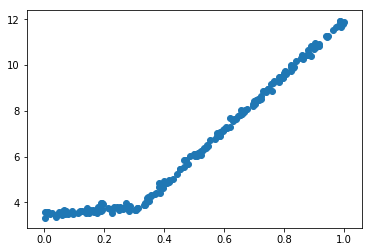

In [28]:
data1 = np.array(loadData('exp2.txt'))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data1[:,0], data1[:,1])
plt.show()
